In [1]:
import tensorflow as tf
from tensorflow import keras
from scipy.stats import uniform
from keras.models import Sequential
from keras.layers import Embedding, Dropout, LSTM, Dense, Attention
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasClassifier
from keras import regularizers
from sklearn.model_selection import  RandomizedSearchCV
from collections import Counter
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer

# define attention layer
from keras.layers import Layer
from keras import backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W = self.add_weight(name='attention_weights', 
                                 shape=(input_shape[-1], 1),
                                 initializer='uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Compute attention scores
        attention_scores = K.dot(x, self.W)
        attention_scores = K.squeeze(attention_scores, axis=-1)
        attention_weights = K.softmax(attention_scores)

        # Apply attention weights
        weighted_input = x * K.expand_dims(attention_weights)

        # Sum over timesteps
        context_vector = K.sum(weighted_input, axis=1)

        return context_vector

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

# define the model
def create_lstm_model(units, vocab_length, embedding_matrix, max_len, dropout):
    lstm_model = Sequential()
    embedding_layer = Embedding(vocab_length, 200, weights=[embedding_matrix], input_length=max_len, trainable=False)
    lstm_model.add(embedding_layer)
    lstm_model.add(Dropout(dropout))
    lstm_model.add(LSTM(units, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', return_sequences=True))
    lstm_model.add(AttentionLayer())
    lstm_model.add(Dense(5, activation='softmax', kernel_initializer='ones'))
    lstm_model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['acc'])
    return lstm_model


# fix random seed for reproducibility
#tf.random.set_seed(7)

df = pd.read_csv('../../data/normalized_tweets.csv')
df = df[df['cyberbullying_type'] != 'other_cyberbullying']
# Reset index after filtering out the class
df.reset_index(drop=True, inplace=True)
#df["cyberbullying_type"].value_counts()

### try different length based on tweet lentgh
df['text_len'] = [len(text.split()) for text in df.tweet_text]
#max_len = np.max(df['text_len'])
#avg_len = np.mean(df['text_len'])
#avg_len = int(avg_len)
#print(avg_len)
avg_len = 35
# checks on tweets length
count = (df['text_len'] >= 35).sum()
print("Number of values greater than or equal to 35:", count)


X, y = df["tweet_text"], df["cyberbullying_type"]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform label encoder on the target variable
y = label_encoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#Each word in input used as a key, while a unique index is used as the value of the key 
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x_train)

X_train = word_tokenizer.texts_to_sequences(x_train)
X_test = word_tokenizer.texts_to_sequences(x_test)

vocab_length = len(word_tokenizer.word_index) + 1

print(vocab_length)

####

X_train = pad_sequences(X_train, padding = 'pre', maxlen = avg_len)
X_test = pad_sequences(X_test, padding = 'pre', maxlen = avg_len)

# Load GloVe word embeddings and create a dictionary that willl contain words as keys, and their corresponging embedding list as values. 
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('../../glove_embeddings/glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_length, 200)) ## change if the dimention of embedding changes above
i = 0
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        i = i + 1
print(i)

Number of values greater than or equal to 35: 100
31490
8122


In [2]:
X_train[1]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0, 13414,    11,   948,   971,   110],
      dtype=int32)

In [3]:
#import warnings
#warnings.filterwarnings("ignore")

model = KerasClassifier(model=create_lstm_model, units=256, batch_size=64, dropout=0.2, validation_split=0.2,optimizer__learning_rate=0.1, vocab_length=vocab_length, embedding_matrix=embedding_matrix, max_len=avg_len)

# Define the grid search parameters
param_grid = dict(optimizer__learning_rate=[0.01, 0.03, 0.1],
                dropout=[0.5, 0.8], epochs=[20],
                units=[128], batch_size=[4, 8, 16])

# Perform grid search
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,refit=True,cv=3)
grid_result = grid.fit(X_train, y_train, callbacks=[early_stopping])

Epoch 1/20
1004/1004 [==============================] - 14s 13ms/step - loss: 0.9342 - acc: 0.6490 - val_loss: 0.5193 - val_acc: 0.8236
Epoch 2/20
1004/1004 [==============================] - 13s 13ms/step - loss: 0.6032 - acc: 0.7830 - val_loss: 0.4247 - val_acc: 0.8455
Epoch 3/20
1004/1004 [==============================] - 13s 12ms/step - loss: 0.5221 - acc: 0.8073 - val_loss: 0.3764 - val_acc: 0.8590
Epoch 4/20
1004/1004 [==============================] - 13s 12ms/step - loss: 0.4720 - acc: 0.8263 - val_loss: 0.3320 - val_acc: 0.8807
Epoch 5/20
1004/1004 [==============================] - 13s 13ms/step - loss: 0.4404 - acc: 0.8367 - val_loss: 0.3098 - val_acc: 0.8876
Epoch 6/20
1004/1004 [==============================] - 13s 13ms/step - loss: 0.4206 - acc: 0.8445 - val_loss: 0.3058 - val_acc: 0.8894
Epoch 7/20
1004/1004 [==============================] - 13s 13ms/step - loss: 0.4038 - acc: 0.8478 - val_loss: 0.2895 - val_acc: 0.8919
Epoch 8/20
1004/1004 [==========================

KeyboardInterrupt: 

In [ ]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
    #print("%f (%f) wit h: %r" % (mean, stdev, param))

Best: 0.931801 using {'units': 128, 'optimizer__learning_rate': 0.03, 'epochs': 20, 'dropout': 0.5, 'batch_size': 4}


In [ ]:
from joblib import dump, load

# save model
#estimator = grid_result.best_estimator_
dump(estimator, "model_ES_093.joblib")

INFO:tensorflow:Assets written to: ram://e29bff5162224e2cb2001604326e59f2/assets


INFO:tensorflow:Assets written to: ram://e29bff5162224e2cb2001604326e59f2/assets


['model_ES_093.joblib']

## Plotting

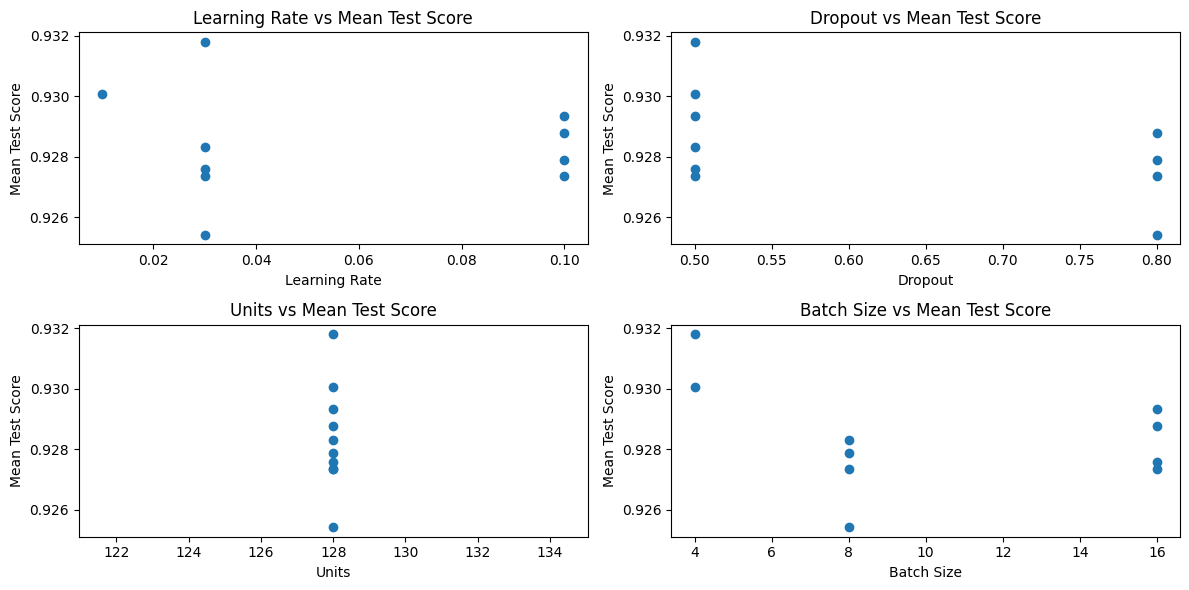

Best parameters: {'units': 128, 'optimizer__learning_rate': 0.03, 'epochs': 20, 'dropout': 0.5, 'batch_size': 4}
Best mean test score: 0.9318006140027411


In [ ]:
import matplotlib.pyplot as plt

# Access grid search results
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']

# Extract parameter values for plotting
learning_rates = [param['optimizer__learning_rate'] for param in params]
dropouts = [param['dropout'] for param in params]
units = [param['units'] for param in params]
batch_sizes = [param['batch_size'] for param in params]

# Plotting the mean test scores for different parameter combinations
plt.figure(figsize=(12, 6))

# Plot for learning rate vs mean test score
plt.subplot(2, 2, 1)
plt.scatter(learning_rates, means)
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test Score')
plt.title('Learning Rate vs Mean Test Score')

# Plot for dropout vs mean test score
plt.subplot(2, 2, 2)
plt.scatter(dropouts, means)
plt.xlabel('Dropout')
plt.ylabel('Mean Test Score')
plt.title('Dropout vs Mean Test Score')

# Plot for units vs mean test score
plt.subplot(2, 2, 3)
plt.scatter(units, means)
plt.xlabel('Units')
plt.ylabel('Mean Test Score')
plt.title('Units vs Mean Test Score')

# Plot for batch size vs mean test score
plt.subplot(2, 2, 4)
plt.scatter(batch_sizes, means)
plt.xlabel('Batch Size')
plt.ylabel('Mean Test Score')
plt.title('Batch Size vs Mean Test Score')

plt.tight_layout()
plt.show()

# Print best parameters and best score
print("Best parameters:", grid_result.best_params_)
print("Best mean test score:", grid_result.best_score_)